Ici , on entraine le modele lstm manuellement sur ce bout de code. 

Voici 2 exemples de modeles :
le 1er code est pour les données entrainé sur 1 mois , et le deuxième est entrainé sur 1 mois et demi(extended = 1.5 mois)

X_train shape: (460, 168, 76)
y_train shape: (460, 1, 63)
Epoch 1/110


c:\Users\Admin\Desktop\données_V1\tf-gpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.2528 - mae: 0.2528 - mape: 76482120.0000 - mse: 0.0967 - val_loss: 0.1529 - val_mae: 0.1529 - val_mape: 3924811.7500 - val_mse: 0.0542
Epoch 2/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.1208 - mae: 0.1208 - mape: 5445938.5000 - mse: 0.0386 - val_loss: 0.1072 - val_mae: 0.1072 - val_mape: 5482107.0000 - val_mse: 0.0328
Epoch 3/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.1010 - mae: 0.1010 - mape: 7171151.0000 - mse: 0.0305 - val_loss: 0.0939 - val_mae: 0.0939 - val_mape: 5923205.5000 - val_mse: 0.0241
Epoch 4/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0849 - mae: 0.0849 - mape: 7271496.0000 - mse: 0.0208 - val_loss: 0.0854 - val_mae: 0.0854 - val_mape: 5134440.5000 - val_mse: 0.0204
Epoch 5/110
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0807 - mae: 0.0807 - mape: 6814923.5000 - mse: 0.0184 - val_loss: 0.0771 - val_mae: 0.0771 - val_mape: 4683908.5000 - val_mse: 0.0163
Epoch 6/110
12/12 ━━━━━━━━━━━━━

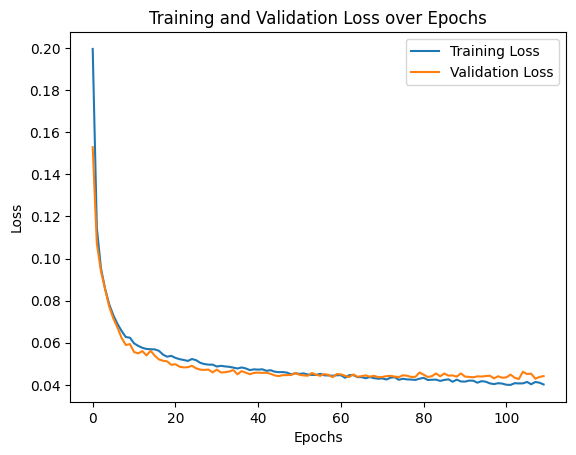

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError
import joblib
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        if indices[-1] >= len(dataset):
            break
        # Créer les séquences pour les données
        data_seq = dataset.iloc[indices].values
        data.append(data_seq)
        
        # Créer les séquences pour les labels
        if single_step:
            label_seq = target.iloc[i+target_size].values
        else:
            label_seq = target.iloc[i:i+target_size].values
        
        if len(label_seq) == target_size:
            labels.append(label_seq)
        else:
            data.pop()

    return np.array(data), np.array(labels)



df = pd.read_csv('1month_meteo_data_en.csv')


features = df[['Hour', 'DayOfWeek', 'DayOfMonth','Month', 'temperature(degC)', 'point_de_rosee(degC)', 
               'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
               'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']]

targets =df[[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]]

scaler_features = StandardScaler()
features = scaler_features.fit_transform(features)

scaler_targets = MinMaxScaler()
targets = scaler_targets.fit_transform(targets)

joblib.dump(scaler_features, 'scaler_features_1month.pkl')

joblib.dump(scaler_targets, 'scaler_target_1month.pkl')

features_df = pd.DataFrame(features, columns=['Hour', 'DayOfWeek', 'DayOfMonth','Month', 'temperature(degC)', 
                                              'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                                              'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                                              'rafale_vent_max(km/h)', 'pression(hPa)'])

targets_df = pd.DataFrame(targets,columns=[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')])

features_df.index = df.index
targets_df.index = df.index
features_with_targets = pd.concat([features_df, targets_df], axis=1)

# Définir les paramètres de la séquence
start_index = 0
end_index = len(df) - 1
history_size = 168  # Une semaine d'historique
target_size = 1  # Prédire les prochaines 12 heures


X, y = multivariate_data(features_with_targets, targets_df, start_index, end_index, history_size, target_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
l2_reg = l2(0.005)

model = Sequential()

# LSTM avec régularisation L2
model.add(LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#               kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg))
#model.add(BatchNormalization()) 
# model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
#model.add(LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(BatchNormalization()) 
#model.add(Dropout(0.2))
# model.add(LSTM(50))
model.add(Dense(y_train.shape[1] * y_train.shape[2]))  # Prédire toutes les colonnes cibles pour les 12 heures suivantes
model.add(Activation('sigmoid'))
model.add(Reshape((target_size, y_train.shape[2])))  # Reshape les prédictions pour qu'elles aient la bonne forme

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate,clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mae', metrics=[
                  MeanAbsoluteError(name='mae'),
                  MeanSquaredError(name='mse'),
                  MeanAbsolutePercentageError(name='mape')])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('1month12.keras', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_split=0.2, epochs=110, batch_size=32,
                    callbacks=[ model_checkpoint])
loss, mae, mse, mape = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')
print(f'Test MAPE: {mape:.2f}%')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

X_train shape: (806, 168, 76)
y_train shape: (806, 1, 63)


c:\Users\Admin\Desktop\données_V1\tf-gpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.2272 - mae: 0.2272 - mape: 62804788.0000 - mse: 0.0820 - val_loss: 0.1485 - val_mae: 0.1485 - val_mape: 10084304.0000 - val_mse: 0.0490
Epoch 2/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.1504 - mae: 0.1504 - mape: 10140734.0000 - mse: 0.0522 - val_loss: 0.1104 - val_mae: 0.1104 - val_mape: 6095383.5000 - val_mse: 0.0351
Epoch 3/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.1109 - mae: 0.1109 - mape: 6737422.0000 - mse: 0.0343 - val_loss: 0.0870 - val_mae: 0.0870 - val_mape: 6476619.0000 - val_mse: 0.0224
Epoch 4/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0950 - mae: 0.0950 - mape: 6259798.0000 - mse: 0.0256 - val_loss: 0.0813 - val_mae: 0.0813 - val_mape: 4162073.7500 - val_mse: 0.0199
Epoch 5/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0882 - mae: 0.0882 - mape: 5919397.5000 - mse: 0.0215 - val_loss: 0.0718 - val_mae: 0.0718 - val_mape: 4204564.5000 - val_mse: 0.0149
Epoch 6/120


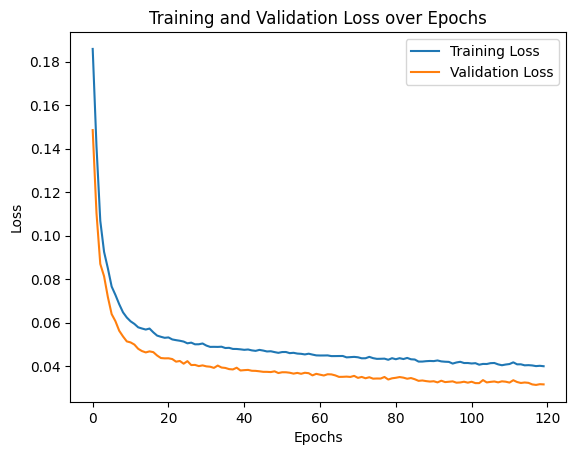

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.layers import BatchNormalization

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        if indices[-1] >= len(dataset):
            break
        # Créer les séquences pour les données
        data_seq = dataset.iloc[indices].values
        data.append(data_seq)
        
        # Créer les séquences pour les labels
        if single_step:
            label_seq = target.iloc[i+target_size].values
        else:
            label_seq = target.iloc[i:i+target_size].values
        
        if len(label_seq) == target_size:
            labels.append(label_seq)
        else:
            data.pop()

    return np.array(data), np.array(labels)



df = pd.read_csv('extended_meteo_data_en.csv')


features = df[['DayOfWeek', 'Hour', 'DayOfMonth','Month', 'temperature(degC)', 'point_de_rosee(degC)', 
               'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
               'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']]
targets = df[[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]]

# Standardisation des features
scaler_features = StandardScaler()
features = scaler_features.fit_transform(features)
joblib.dump(scaler_features, 'scaler_features.pkl')


# Normalisation des targets
scaler_targets = MinMaxScaler()
targets = scaler_targets.fit_transform(targets)
joblib.dump(scaler_targets, 'scaler_targets.pkl')
features_df = pd.DataFrame(features, columns=['DayOfWeek', 'Hour', 'DayOfMonth','Month', 'temperature(degC)', 
                                              'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                                              'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                                              'rafale_vent_max(km/h)', 'pression(hPa)'])

targets_df = pd.DataFrame(targets, columns=[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')])

features_df.index = df.index
targets_df.index = df.index
features_with_targets = pd.concat([features_df, targets_df], axis=1)

# Définir les paramètres de la séquence
start_index = 0
end_index = len(df) - 1
history_size = 168  # Une semaine d'historique
target_size = 1  # Prédire les prochaines 12 heures
step = 1

X, y = multivariate_data(features_with_targets, targets_df, start_index, end_index, history_size, target_size, step)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

l2_reg = l2(0.01)

# Construire le modèle LSTM avec régularisation L2
model = Sequential()

# LSTM avec régularisation L2
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#               kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(BatchNormalization()) 
model.add(Dropout(0.2))
# model.add(LSTM(50))
model.add(Dense(y_train.shape[1] * y_train.shape[2]))  # Prédire toutes les colonnes cibles pour les 12 heures suivantes
model.add(Activation('sigmoid'))
model.add(Reshape((target_size, y_train.shape[2])))  # Reshape les prédictions pour qu'elles aient la bonne forme

learning_rate = 0.005
optimizer = Adam(learning_rate=learning_rate)#, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='mae', metrics=[
                  MeanAbsoluteError(name='mae'),
                  MeanSquaredError(name='mse'),
                  MeanAbsolutePercentageError(name='mape')])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_extended23.keras', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_split=0.2, epochs=120, batch_size=32,
                    callbacks=[ model_checkpoint])
loss, mae, mse, mape = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')
print(f'Test MAPE: {mape:.2f}%')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()


Ensuite on affiche les metriques correspondantes à ces modèles:

le premier code pour les modeles entrainé sur 1mois, et le 2ème sur 1 mois et demi.
 

In [4]:
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        if indices[-1] >= len(dataset):
            break
        data_seq = dataset.iloc[indices].values
        data.append(data_seq)

        if single_step:
            label_seq = target.iloc[i+target_size].values
        else:
            label_seq = target.iloc[i:i+target_size].values
        
        if len(label_seq) == target_size:
            labels.append(label_seq)
        else:
            data.pop()

    return np.array(data), np.array(labels)

df = pd.read_csv('1month_meteo_data_en.csv')


features = df[['Hour', 'DayOfWeek', 'DayOfMonth','Month', 'temperature(degC)', 'point_de_rosee(degC)', 
               'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
               'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']]
targets = df[[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]]

scaler_features = joblib.load('scaler_features_1month.pkl')
features = scaler_features.transform(features)

scaler_targets = joblib.load('scaler_target_1month.pkl')
targets = scaler_targets.transform(targets)

features_df = pd.DataFrame(features, columns=['Hour','DayOfWeek', 'DayOfMonth','Month', 'temperature(degC)', 
                                              'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                                              'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                                              'rafale_vent_max(km/h)', 'pression(hPa)'])

targets_df = pd.DataFrame(targets, columns=[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')])

features_df.index = df.index
targets_df.index = df.index
features_with_targets = pd.concat([features_df, targets_df], axis=1)
# Définir les paramètres de la séquence
start_index = 0
end_index = len(df) - 1
history_size = 168  # Une semaine d'historique
target_size = 1 # Prédire les prochaines 12 heures
step = 1
X, y = multivariate_data(features_with_targets, targets_df, start_index, end_index, history_size, target_size, step)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model=load_model('1month10.keras')
model.summary()
predictions = model.predict(X_test)


predictions_inversed = scaler_targets.inverse_transform(predictions.reshape(-1, predictions.shape[-1]))
predictions_inversed = predictions_inversed.reshape(predictions.shape)
predictions_inversed = np.round(predictions_inversed).astype(int)  # Arrondir les prédictions
predictions_inversed = np.clip(predictions_inversed, 0, None) 

y_test_inversed = scaler_targets.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_test_inversed = y_test_inversed.reshape(y_test.shape)
mae_real = np.mean(np.abs(y_test_inversed - predictions_inversed))
mse_real = np.mean(np.square(y_test_inversed - predictions_inversed))
mape_real = np.mean(np.abs((y_test_inversed - predictions_inversed) / np.maximum(np.abs(y_test_inversed), np.finfo(float).eps))) * 100

print(f'Test MAE (real scale): {mae_real}')
y_test_flat = y_test_inversed.reshape(-1, y_test_inversed.shape[-1])
predictions_flat = predictions_inversed.reshape(-1, predictions_inversed.shape[-1])

r2 = r2_score(y_test_flat, predictions_flat)
print(f'R² Score (real scale): {r2:.4f}')
epsilon = 1e-2  # Une petite valeur pour éviter la division par zéro
mape_real = np.mean(np.abs((y_test_inversed - predictions_inversed) / (np.abs(y_test_inversed) + epsilon))) * 100
print(f'Test MAPE (real scale): {mape_real:.2f}%')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 168, 60)        │        32,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 168, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 63)             │         3,843 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 63)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,291 (770.67 KB)

 Trainable params: 65,763 (256.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 131,528 (513.79 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Test MAE (real scale): 4.866447728516694
R² Score (real scale): 0.8203
Test MAPE (real scale): 416.12%


In [6]:
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        if indices[-1] >= len(dataset):
            break
        # Créer les séquences pour les données
        data_seq = dataset.iloc[indices].values
        data.append(data_seq)
        
        # Créer les séquences pour les labels
        if single_step:
            label_seq = target.iloc[i+target_size].values
        else:
            label_seq = target.iloc[i:i+target_size].values
        
        if len(label_seq) == target_size:
            labels.append(label_seq)
        else:
            data.pop()

    return np.array(data), np.array(labels)



df = pd.read_csv('extended_meteo_data_en.csv')


features = df[['DayOfWeek', 'Hour', 'DayOfMonth','Month','temperature(degC)', 'point_de_rosee(degC)', 
               'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
               'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']]
targets = df[[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]]

scaler_features = joblib.load('scaler_features_extended.pkl')
features = scaler_features.transform(features)

scaler_targets = joblib.load('scaler_target_extended.pkl')
targets = scaler_targets.transform(targets)

features_df = pd.DataFrame(features, columns=['DayOfWeek', 'Hour', 'DayOfMonth','Month', 'temperature(degC)', 
                                              'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                                              'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                                              'rafale_vent_max(km/h)', 'pression(hPa)'])

targets_df = pd.DataFrame(targets, columns=[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')])

features_df.index = df.index
targets_df.index = df.index
features_with_targets = pd.concat([features_df, targets_df], axis=1)

# Définir les paramètres de la séquence
start_index = 0
end_index = len(df) - 1
history_size = 168  # Une semaine d'historique
target_size = 1 # Prédire les prochaines 12 heures
step = 1

X, y = multivariate_data(features_with_targets, targets_df, start_index, end_index, history_size, target_size, step)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model=load_model('best_extended22.keras')
model.summary()
predictions = model.predict(X_test)


predictions_inversed = scaler_targets.inverse_transform(predictions.reshape(-1, predictions.shape[-1]))
predictions_inversed = predictions_inversed.reshape(predictions.shape)
predictions_inversed = np.round(predictions_inversed).astype(int)  # Arrondir les prédictions
predictions_inversed = np.clip(predictions_inversed, 0, None) 

y_test_inversed = scaler_targets.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
y_test_inversed = y_test_inversed.reshape(y_test.shape)

mae_real = np.mean(np.abs(y_test_inversed - predictions_inversed))

print(f'Test MAE (real scale): {mae_real}')

y_test_flat = y_test_inversed.reshape(-1, y_test_inversed.shape[-1])
predictions_flat = predictions_inversed.reshape(-1, predictions_inversed.shape[-1])
r2 = r2_score(y_test_flat, predictions_flat)
print(f'R² Score (real scale): {r2:.4f}')
epsilon = 1e-2  
mape_real = np.mean(np.abs((y_test_inversed - predictions_inversed) / (np.abs(y_test_inversed) + epsilon))) * 100

print(f'Test MAPE (real scale): {mape_real:.2f}%')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 168, 100)       │        70,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 63)             │         3,213 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 63)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,641 (1.19 MB)

 Trainable params: 104,213 (407.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,428 (814.18 KB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Test MAE (real scale): 3.5462831997485464
R² Score (real scale): 0.8608
Test MAPE (real scale): 371.77%


Ensuite, vous trouverez le code responsable de faire la prédiction itérative.

In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from meteostat import Point, Hourly
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from datetime import timedelta

def prepare_initial_data(df, required_columns, history_size):
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Les colonnes suivantes sont manquantes dans les données d'entrée: {missing_cols}")
    
    df = df[required_columns]
    initial_data = df.tail(history_size)
    return initial_data

def iterative_prediction_with_meteo(model, initial_data, num_days_to_predict, history_size, target_size, scaler_features, scaler_targets, location):
    
    num_predictions = num_days_to_predict * 24 // target_size
    
    all_predictions = []

    for i in range(num_predictions):
        last_week_data = initial_data[-history_size:]  # Prendre la dernière semaine de données
        last_week_data_without_datetime = last_week_data.drop(columns=['Datetime'])
        last_datetime = pd.to_datetime(last_week_data['Datetime'].iloc[-1])

        if pd.isna(last_datetime):
            raise ValueError("La colonne 'Datetime' contient une valeur NaT (Not a Timestamp) ou est manquante.")
        #print("Last week data:")
        #print(last_week_data[['Datetime']].tail(10))  # Affichez les 10 dernières valeurs de 'Datetime' pour vérifier les données

        prediction_dates = pd.date_range(start=last_datetime + timedelta(hours=1), periods=target_size, freq='h')

        features_seq = np.array(last_week_data_without_datetime).reshape((1, history_size, last_week_data_without_datetime.shape[1]))
        
        predicted_targets_scaled = model.predict(features_seq)
        predicted_targets_scaled = predicted_targets_scaled.reshape(target_size, -1)
        #print(f'Forme après reshape: {predicted_targets_scaled.shape}')
        predicted_targets = scaler_targets.inverse_transform(predicted_targets_scaled)
        predicted_columns = scaler_targets.feature_names_in_  # Assurez-vous que cela contient les noms de colonnes corrects

        
        predicted_targets_df = pd.DataFrame(predicted_targets, columns=predicted_columns)
    
        predicted_targets_df['Datetime'] = prediction_dates

        predicted_targets_scaled_df = pd.DataFrame(predicted_targets_scaled, index=prediction_dates, columns=scaler_targets.feature_names_in_)        
        predicted_targets_scaled_df['Datetime'] = prediction_dates

        start = prediction_dates[0]
        end = prediction_dates[-1]
        meteo_data = Hourly(location, start, end).fetch()
        
        meteo_data['DayOfWeek'] = meteo_data.index.dayofweek
        meteo_data['Hour'] = meteo_data.index.hour
        meteo_data['DayOfMonth'] = meteo_data.index.day
        meteo_data['Month'] = meteo_data.index.month
        

        meteo_data.rename(columns={
            'temp': 'temperature(degC)',
            'dwpt': 'point_de_rosee(degC)',
            'rhum': 'humidite(%)',
            'prcp': 'precipitations(mm)',
            'snow': 'neige(mm)',
            'wdir': 'vent_direction(deg)',
            'wspd': 'vent_moyen(km/h)',
            'wpgt': 'rafale_vent_max(km/h)',
            'pres': 'pression(hPa)',
            'tsun': 'ensoleillement(H)'
        }, inplace=True)

        meteo_data['Datetime'] = meteo_data.index
        meteo_data.reset_index(drop=True, inplace=True)
        meteo_data.fillna(0, inplace=True)

        colonnes_souhaitees = [ 'Hour','DayOfWeek', 'DayOfMonth','Month', 'temperature(degC)',
                            'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                            'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                            'rafale_vent_max(km/h)', 'pression(hPa)']

        colonnes_presentes = [col for col in colonnes_souhaitees if col in meteo_data.columns]
        meteo_data = meteo_data[colonnes_presentes]

        colonnes_indesirables = ['coco']  # Ajouter d'autres colonnes si nécessaire
        meteo_data = meteo_data.drop(columns=[col for col in colonnes_indesirables if col in initial_data.columns])
        #print(meteo_data)
        meteo_data = meteo_data[scaler_features.feature_names_in_]
        meteo_data_scaled = scaler_features.transform(meteo_data)

        meteo_df = pd.DataFrame(meteo_data_scaled, columns=meteo_data.columns)
        meteo_df['Datetime'] = prediction_dates

        next_input_df = pd.merge(meteo_df, predicted_targets_scaled_df, left_on='Datetime', right_index=True,how = 'left')
        

        expected_columns = list(scaler_features.feature_names_in_) + list(scaler_targets.feature_names_in_)
        #next_input_df = next_input_df[expected_columns]
        next_input_df = next_input_df[expected_columns]
        next_input_df.insert(0, 'Datetime', prediction_dates)

        initial_data = pd.concat([initial_data, next_input_df], ignore_index=True)
        all_predictions.append(pd.concat([meteo_df[['Datetime']], predicted_targets_df], axis=1))
    
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    target_columns = list(scaler_targets.feature_names_in_)
    final_predictions[target_columns] = final_predictions[target_columns].round().abs().astype(int)
    return final_predictions

df = pd.read_csv('1month_meteo_data_en.csv', parse_dates=['Datetime'])
required_columns = [
    'Datetime',  'Hour','DayOfWeek', 'DayOfMonth','Month', 'temperature(degC)',
    'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 'neige(mm)',
    'vent_direction(deg)', 'vent_moyen(km/h)', 'rafale_vent_max(km/h)',
    'pression(hPa)'
] + [f'{veh_type}-P{poste:02d}' for veh_type in ['2R', 'PL', 'VL'] for poste in [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 24, 25, 26]]


initial_data = prepare_initial_data(df, required_columns, history_size=168)
features = initial_data.iloc[:, 1:14]  # Les 13 premières colonnes sont les features (excluant Datetime)
targets = initial_data.iloc[:, 14:]    # Le reste sont les targets

scaler_features = joblib.load('scaler_features_1month.pkl')
scaler_targets = joblib.load('scaler_target_1month.pkl')

features = features[scaler_features.feature_names_in_]

features = scaler_features.transform(features)
targets = targets[scaler_targets.feature_names_in_]
targets = scaler_targets.transform(targets)
#targets = scaler_targets.transform(targets)
initial_data = pd.DataFrame(np.hstack((features, targets)), columns=required_columns[1:]) 
initial_data['Datetime'] = df['Datetime'].tail(168).reset_index(drop=True)

initial_data = initial_data[['Datetime'] + required_columns[1:]]
model = load_model('1month10.keras')

predictions = iterative_prediction_with_meteo(
    model=model, 
    initial_data=initial_data, 
    num_days_to_predict=13, 
    history_size=168, 
    target_size=1, 
    scaler_features=scaler_features, 
    scaler_targets=scaler_targets, 
    location=Point(44.8069, -0.6133, 20)  # Talence, près de Bordeaux
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Ceci est un exemple de code pour les modèles entrainé sur un mois et demi.

In [54]:
df = pd.read_csv('extended_meteo_data_en.csv', parse_dates=['Datetime'])


required_columns = ['Datetime'] + list(scaler_features.feature_names_in_) + list(scaler_targets.feature_names_in_)


initial_data = prepare_initial_data(df, required_columns, history_size=168)

features = initial_data.iloc[:, 1:14]  # Les 13 premières colonnes sont les features (excluant Datetime)
targets = initial_data.iloc[:, 14:]    # Le reste sont les targets


scaler_features = joblib.load('scaler_features_extended.pkl')
scaler_targets = joblib.load('scaler_target_extended.pkl')

features = features[scaler_features.feature_names_in_]

features = scaler_features.transform(features)

targets = targets[scaler_targets.feature_names_in_]


targets = scaler_targets.transform(targets)
#targets = scaler_targets.transform(targets)



initial_data = pd.DataFrame(np.hstack((features, targets)), columns=required_columns[1:]) 
initial_data['Datetime'] = df['Datetime'].tail(168).reset_index(drop=True)

initial_data = initial_data[['Datetime'] + required_columns[1:]]
model = load_model('best_extended22.keras')

predictions = iterative_prediction_with_meteo(
    model=model, 
    initial_data=initial_data, 
    num_days_to_predict=19, 
    history_size=168, 
    target_size=1, 
    scaler_features=scaler_features, 
    scaler_targets=scaler_targets, 
    location=Point(44.8069, -0.6133, 20)  # Talence, près de Bordeaux
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


On affiche la prédiction, pour analyser les résultats.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


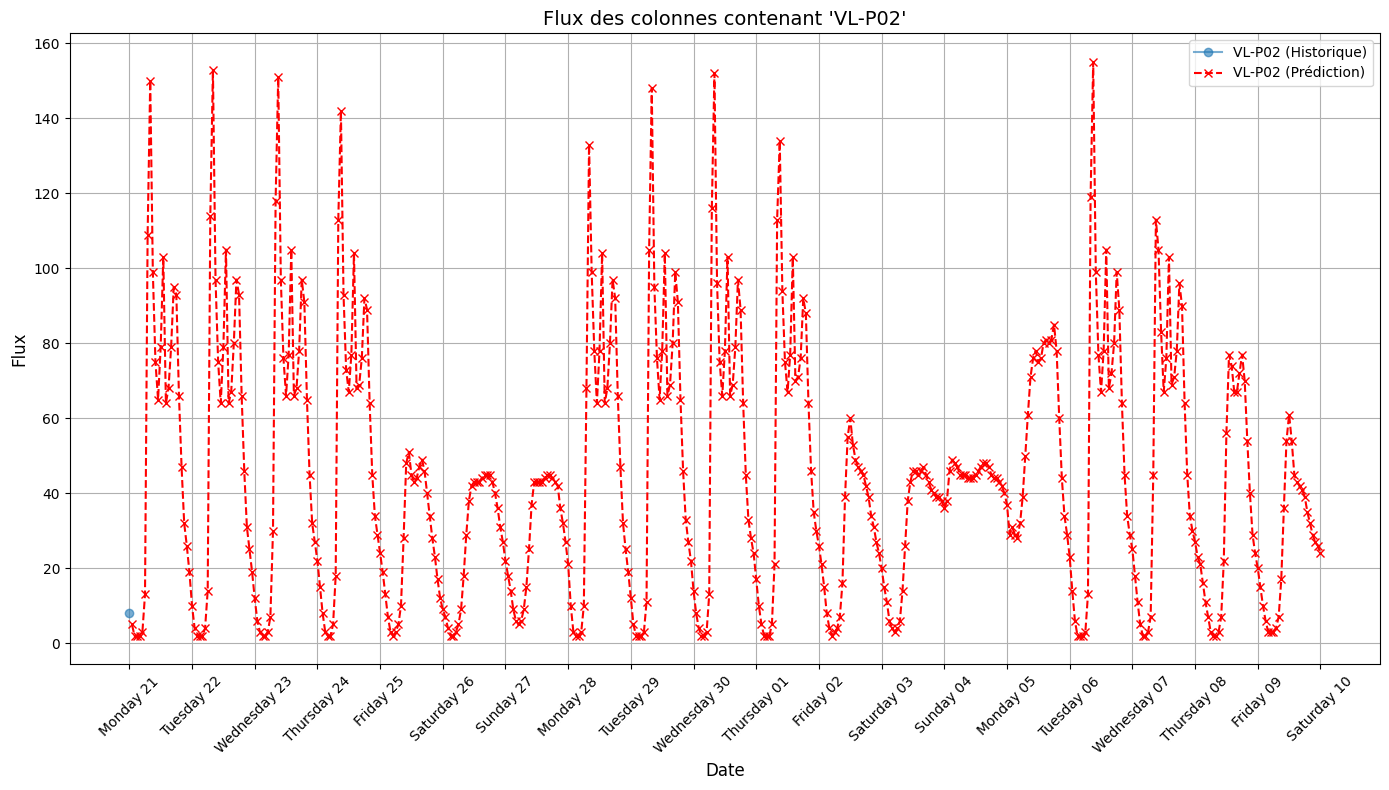

               Datetime  2R-P01  VL-P01  PL-P01  2R-P10  VL-P10  PL-P10  \
0   2022-11-21 01:00:00       1       9       0       0       0       0   
1   2022-11-21 02:00:00       1       6       0       0       0       0   
2   2022-11-21 03:00:00       0       6       0       0       0       0   
3   2022-11-21 04:00:00       0       6       1       0       0       0   
4   2022-11-21 05:00:00       2      15       6       0       0       0   
..                  ...     ...     ...     ...     ...     ...     ...   
451 2022-12-09 20:00:00       5      94       5       0       0       0   
452 2022-12-09 21:00:00       4      83       4       0       0       0   
453 2022-12-09 22:00:00       4      74       4       0       0       0   
454 2022-12-09 23:00:00       4      71       3       0       0       0   
455 2022-12-10 00:00:00       3      62       3       0       0       0   

     2R-P12  VL-P12  PL-P12  ...  2R-P06  VL-P06  PL-P06  2R-P08  VL-P08  \
0         0       0    

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Dictionnaire des jours de la semaine pour le mappage
jours_semaine = {0: 'Lundi', 1: 'Mardi', 2: 'Mercredi', 3: 'Jeudi', 4: 'Vendredi', 5: 'Samedi', 6: 'Dimanche'}
couleurs = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red', 4: 'purple', 5: 'brown', 6: 'pink'}

def plot_flux_with_pattern(data, previous_data=None, pattern=None, days=24):
    if pattern is None:
        print("Veuillez spécifier un motif pour filtrer les colonnes.")
        return

    # Filtrer les colonnes à tracer
    columns_to_plot = [col for col in data.columns if pattern in col]
    if len(columns_to_plot) == 0:
        print(f"Aucune colonne trouvée avec le motif '{pattern}' dans les données.")
        return

    # Supprimer les colonnes en double
    data = data.loc[:, ~data.columns.duplicated()]
    if previous_data is not None:
        previous_data = previous_data.loc[:, ~previous_data.columns.duplicated()]

    try:
        data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')
        if previous_data is not None:
            previous_data['Datetime'] = pd.to_datetime(previous_data['Datetime'], errors='coerce')
    except Exception as e:
        print(f"Erreur lors de la conversion de 'Datetime': {e}")
        return

    # Filtrer les données pour les derniers jours
    last_days = data['Datetime'].max() - pd.Timedelta(days=days)
    data = data[data['Datetime'] >= last_days]
    if previous_data is not None:
        previous_data = previous_data[previous_data['Datetime'] >= last_days]

    # Vérifier les valeurs 'Datetime' manquantes
    if data['Datetime'].isna().sum() > 0:
        print(f"Attention : {data['Datetime'].isna().sum()} valeurs 'Datetime' non valides détectées dans les prédictions.")
    if previous_data is not None and previous_data['Datetime'].isna().sum() > 0:
        print(f"Attention : {previous_data['Datetime'].isna().sum()} valeurs 'Datetime' non valides détectées dans les données historiques.")

    # Créer la figure
    plt.figure(figsize=(14, 8))

    # Tracer les données historiques
    if previous_data is not None:
        for col in columns_to_plot:
            if col in previous_data.columns:
                plt.plot(previous_data['Datetime'], previous_data[col],
                         label=f'{col} (Historique)', alpha=0.6, linestyle='-', marker='o')

    # Tracer les données de prédiction
    for col in columns_to_plot:
        plt.plot(data['Datetime'], data[col],
                 label=f'{col} (Prédiction)', linestyle='--', marker='x', color='red')

    # Configuration des axes
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%A %d'))

    # Labels des axes
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Flux', fontsize=12)

    # Titre et légende
    plt.title(f"Flux des colonnes contenant '{pattern}'", fontsize=14)
    plt.grid(True)
    plt.legend()

    # Affichage du graphique
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#df = pd.read_csv('1month_meteo_data_en.csv')
df = pd.read_csv('extended_meteo_data_en.csv')
plot_flux_with_pattern(predictions, previous_data=df, pattern='VL-P02', days=19)  
print(predictions)

Pour la nouvelle métrique ajouté, on la calcule ici:

On calcule le mae sur la derniere semaine de l'historique.

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error


df = pd.read_csv('1month_meteo_data_en.csv', parse_dates=['Datetime'])
#df = pd.read_csv('extended_meteo_data_en.csv', parse_dates=['Datetime'])
last_two_weeks_data = df.tail(14 * 24)
last_week = last_two_weeks_data.iloc[-7 * 24:]  # Dernière semaine
previous_week = last_two_weeks_data.iloc[:7 * 24]  # Semaine avant la dernière
previous_week_without_datetime = previous_week.drop(columns=['ensoleillement(h)'])

scaler_features = joblib.load('scaler_features_1month.pkl')
scaler_targets = joblib.load('scaler_target_1month.pkl')

# scaler_features = joblib.load('scaler_features_extended.pkl')
# scaler_targets = joblib.load('scaler_target_extended.pkl')

features = last_two_weeks_data[['DayOfWeek', 'Hour', 'DayOfMonth','Month', 'temperature(degC)', 'point_de_rosee(degC)', 
                                'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
                                'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']]
features = features[scaler_features.feature_names_in_]
features_scaled = scaler_features.transform(features)
targets = last_two_weeks_data[[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]]
targets = targets[scaler_targets.feature_names_in_]
targets_scaled = scaler_targets.transform(targets)

features_df = pd.DataFrame(features_scaled, columns=features.columns)
targets_df = pd.DataFrame(targets_scaled, columns=targets.columns)
last_two_weeks_data_scaled = pd.concat([features_df, targets_df], axis=1)
last_two_weeks_data_scaled['Datetime'] = last_two_weeks_data['Datetime'].values
model = load_model('1month10.keras')
#model = load_model('best_extended20.keras')
predictions = iterative_prediction_with_meteo(
    model=model, 
    initial_data=previous_week_without_datetime,  # Semaine précédente utilisée comme données initiales
    num_days_to_predict=7,       # Prédire 7 jours (une semaine)
    history_size=168,            # 168 heures d'historique (une semaine)
    target_size=1,               # Prédire 1 heure à chaque itération
    scaler_features=scaler_features, 
    scaler_targets=scaler_targets, 
    location=Point(44.8069, -0.6133, 20)  # Talence, près de Bordeaux
)

real_values = last_week[targets.columns].values
predicted_values = predictions[targets.columns].values
mae = mean_absolute_error(real_values, predicted_values)
print(f"Mean Absolute Error (MAE) entre les vraies valeurs et les prédictions : {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Mean Absolute Error (MAE) entre les vraies valeurs et les prédictions : 12.2025


Finalement la boucle permettant d'optimiser les hyperparamètres du modele.

In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Activation
from tensorflow.keras.optimizers import Adam

# Chargement des données

df = pd.read_csv('extended_meteo_data_en.csv')

# Préparation des features et des cibles
features = df[['DayOfWeek', 'Hour', 'DayOfMonth', 'temperature(degC)', 'point_de_rosee(degC)', 
               'humidite(%)', 'precipitations(mm)', 'neige(mm)', 'vent_direction(deg)', 
               'vent_moyen(km/h)', 'rafale_vent_max(km/h)', 'pression(hPa)']]
targets = df[[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')]]

# Standardisation des features
scaler_features = StandardScaler()
features = scaler_features.fit_transform(features)

# Normalisation des targets
scaler_targets = MinMaxScaler()
targets = scaler_targets.fit_transform(targets)

features_df = pd.DataFrame(features, columns=['DayOfWeek', 'Hour', 'DayOfMonth', 'temperature(degC)', 
                                              'point_de_rosee(degC)', 'humidite(%)', 'precipitations(mm)', 
                                              'neige(mm)', 'vent_direction(deg)', 'vent_moyen(km/h)', 
                                              'rafale_vent_max(km/h)', 'pression(hPa)'])

targets_df = pd.DataFrame(targets, columns=[col for col in df.columns if col.startswith('2R') or col.startswith('VL') or col.startswith('PL')])

features_df.index = df.index
targets_df.index = df.index
features_with_targets = pd.concat([features_df, targets_df], axis=1)

# Définir les paramètres de la séquence
start_index = 0
end_index = len(df) - 1
history_size = 168  # Une semaine d'historique
target_size = 12  # Prédire les prochaines 12 heures
step = 1

X, y = multivariate_data(features_with_targets, targets_df, start_index, end_index, history_size, target_size, step)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Hyperparamètres à tester
units_list = [50, 100]
dropout_rate_list = [0.2, 0.3, 0.4]
learning_rate_list = [0.001, 0.005]
num_layers_list = [1, 2, 3]
batch_size_list = [16, 32, 64]
epochs_list = [50, 100]

# Variables pour stocker les meilleurs résultats
best_r2_score = -float('inf')  # On cherche à maximiser le R²
best_mae = float('inf')  # On cherche à minimiser le MAE
best_params = {}

# Boucles pour tester les combinaisons d'hyperparamètres
for units in units_list:
    for dropout_rate in dropout_rate_list:
        for learning_rate in learning_rate_list:
            for num_layers in num_layers_list:
                for batch_size in batch_size_list:
                    for epochs in epochs_list:
                        print(f"Testing: units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, num_layers={num_layers}, batch_size={batch_size}, epochs={epochs}")

                        # Créer le modèle
                        model = Sequential()
                        model.add(LSTM(units, return_sequences=(num_layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))
                        model.add(Dropout(dropout_rate))

                        for i in range(1, num_layers - 1):
                            model.add(LSTM(units, return_sequences=True))
                            model.add(Dropout(dropout_rate))

                        if num_layers > 1:
                            model.add(LSTM(units, return_sequences=False))
                            model.add(Dropout(dropout_rate))

                        model.add(Dense(y_train.shape[1] * y_train.shape[2]))
                        model.add(Activation('relu'))
                        model.add(Reshape((target_size, y_train.shape[2])))

                        optimizer = Adam(learning_rate=learning_rate)
                        model.compile(optimizer=optimizer, loss='mae')

                        # Entraîner le modèle
                        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2)

                        # Évaluer le modèle
                        predictions = model.predict(X_test)

                        # Inverser la normalisation
                        predictions_inversed = scaler_targets.inverse_transform(predictions.reshape(-1, predictions.shape[-1]))
                        predictions_inversed = predictions_inversed.reshape(predictions.shape)

                        y_test_inversed = scaler_targets.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
                        y_test_inversed = y_test_inversed.reshape(y_test.shape)

                        y_test_flattened = y_test_inversed.flatten()
                        predictions_flattened = predictions_inversed.flatten()

                        # Calculer R² et MAE
                        r2 = r2_score(y_test_flattened, predictions_flattened)
                        mae = mean_absolute_error(y_test_flattened, predictions_flattened)
                        print(f"R²: {r2}, MAE: {mae}")

                        # Si le modèle est meilleur, sauvegarder les hyperparamètres
                        if r2 > best_r2_score or (r2 == best_r2_score and mae < best_mae):
                            best_r2_score = r2
                            best_mae = mae
                            best_params = {
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'num_layers': num_layers,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'r2': r2,
                                'mae': mae
                            }

# Afficher les meilleurs hyperparamètres trouvés
print(f"Best R² Score: {best_r2_score}")
print(f"Best MAE: {best_mae}")
print(f"Best Parameters: {best_params}")


Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1, batch_size=16, epochs=50


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
R²: 0.9535970817086837, MAE: 6.058363687327737
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1, batch_size=16, epochs=100


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
R²: 0.964928155554354, MAE: 5.1511041620892355
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1, batch_size=32, epochs=50


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R²: 0.9493753835947089, MAE: 6.3923232962034096
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1, batch_size=32, epochs=100


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
R²: 0.9625553921221929, MAE: 5.549792660327279
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1, batch_size=64, epochs=50


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
R²: 0.9390758182437752, MAE: 7.246746005669077
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=1, batch_size=64, epochs=100


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
R²: 0.9568470492090254, MAE: 5.928128731244619
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=2, batch_size=16, epochs=50


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
R²: 0.9334982596052013, MAE: 7.135068560498354
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=2, batch_size=16, epochs=100


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
R²: 0.9603322251802479, MAE: 5.370034692054156
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=2, batch_size=32, epochs=50


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
R²: 0.92088326298613, MAE: 7.81357891902636
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=2, batch_size=32, epochs=100


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
R²: 0.9643495981044719, MAE: 5.293161614584849
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=2, batch_size=64, epochs=50


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
R²: 0.9398732612406945, MAE: 7.120116147530147
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=2, batch_size=64, epochs=100


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
R²: 0.9498405021605795, MAE: 6.197206930584612
Testing: units=50, dropout_rate=0.2, learning_rate=0.001, num_layers=3, batch_size=16, epochs=50


KeyboardInterrupt: 